## WallStreetQuant Course Project

#### Author: Kevin Tan YueJun
##### Strategy 1: Cross-Sectional Momentum Strategy - Rolling Return

**Statistical Arbitrage in Cryptocurrencies** (Background)

*Statistical arbitrage* is a class of strategies that tries to discover price-volume patterns that predict returns. It is one of the most popular and successful quantitative hedge-fund strategies, and given that the cryptocurrency markets are still relatively new, it should provide fertile grounds for finding market inefficiencies using statistical arbitrage techniques. The two main patterns exploited in statistical arbitrage are momentum and reversal. 

---

**Key Intuitions and Assumptions Made**:
- Strategy employed is: **Cross Sectional Momentum Strategy (Rolling Mean)**
- For portfolio performance evaluation, the following metrics will be used:
  - *returns, volatility, sharpes, max drawdowns, alpha / beta, holding period, information ratio*
- Benchmark comparison: A **buy-and-hold** strategy for Bitcoin (BTCUSDT) over the period of analysis
- Period of Analysis: 5 year time horizon from 1-Jan-2020 to 31-Dec-2025
  - Training Data (4 years worth of data from 2020 - 2024)
  - Test Data (1 year worth of data from 2025)
- Portfolio Allocation and Rebalancing Strategy
  - Contrarian to the buy-and-hold technique, our momentum strategy will general long and short signals that signify a change in position of a given asset across time. This ensures that we will not be in the same position for any given asset across time. Furthermore, cross-sectional ranking of assets would lead to a possible rebalancing (I,e changing of weights in our current asset holdings, or removal/addition of existing/new trading pairs into our portfolio)
  
  Method for rebalancing: Rank-Order
  -	Nature of ranking: Trading pairs are ranked based on their simple rolling window return
  -	Base on the ranks, we will long our top X trading pairs by rank order.
  
  Method for trading-pairs allocation (% across long)
  -	Main approach: Equal weighted portfolio of trading pairs
  - Potential improvements: Equal-volatility, Risk-Parity, Equal Dollar etc

---

**Order/Section of the Notebook**
1. Import Libraries and Data
2. Parameter Initialisation
3. Data Retrieval and Formatting
4. Crypto Strategy
    - Grid Search
    - Signal Generation and Backtesting
    - Running the strategy on our basket of trading pairs 
5. Performance Evaluation
6. Strategy Improvements
    - Equal Volatility Weights
7. Modelling Transaction Cost and other Factors
8. Potential Model Shortfalls and Limitations
9. Conclusion

#### **1. Import Libraries and Data**

The following section will be a list of all the libraries that we will import for our testing

In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import seaborn as sns

from matplotlib import pyplot as plt
from binance.client import Client
from datetime import datetime

#### **2. Parameter Initialisation**

We will initialise all our global parameters variables here

In [2]:
start_date, end_date = "1 Jan, 2020", "31 Dec, 2025"

# Train-test split by dates
# Train 2020 -2024, Test 2025
train, test = "2020-01-01", "2024-12-31"
market_order_fee = 0.0020  # 0.2% per trade
limit_order_fee = 0.0007  # 0.07% per trade

#### **3. Data Retrieval and Formatting**

Download the open, high, low and close data for our basket of cryptocurrencies. For the trading pairs that we are using, they will be retrieved from the **Binance** website using a public endpoint

In [3]:
# Retrieving a list of all available coins from Binance
client = Client()
futures_exchange_info = client.futures_exchange_info()  # request info on all futures symbols
trading_pairs = [info['symbol'] for info in futures_exchange_info['symbols']]
print(len(trading_pairs), "trading pairs found.")
print("First 10 trading pairs: ",trading_pairs[:10])  # print the first 10 trading pairs

660 trading pairs found.
First 10 trading pairs:  ['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'LTCUSDT', 'TRXUSDT', 'ETCUSDT', 'LINKUSDT', 'XLMUSDT', 'ADAUSDT']


**Data Download**

We will define a method to download the historical data for a basket of cryptocurrencies

In [4]:
# Method to format the downloaded data from Binance, which returns the data in a list of lists
def format_binance(data):
  columns = ['open_time','open','high','low','close','volume','close_time','quote_volume','num_trades','taker_base_volume','taker_quote_volume','ignore']
  data = pd.DataFrame(data, columns = columns)
  
  # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
  data['open_time'] = data['open_time'].map(lambda x: datetime.fromtimestamp(x/1000))
  data['close_time'] = data['close_time'].map(lambda x: datetime.fromtimestamp(x/1000))
  
  # For our analysis, we only need the date and close columns. As for the date column, we will use the open_time column
  data = data[['open_time','close']]
  data['open_time'] = pd.to_datetime(data['open_time']).dt.date
  data.rename(columns={'open_time':'date'}, inplace=True)
  return data

def download_data(trading_pairs):
  """ Use client.KLINE_INTERVAL and tab to check the available time intervals for download
  E.g
  - client.KLINE_INTERVAL_1MINUTE
  - client.KLINE_INTERVAL_1HOUR
  - client.KLINE_INTERVAL_2HOUR
  - client.KLINE_INTERVAL_1DAY
  - client.KLINE_INTERVAL_1WEEK
  ...etc
  """
  crypto_data = {}
  for symbol in trading_pairs:
    # We will first check to see if the trading pair data (pkl file) exists on our local machine before downloading it from Binance
    directory = f"Crypto-Data/{symbol}_data.pkl"
    if os.path.exists(directory):
      crypto_data[symbol] = pd.read_pickle(directory)
      continue
    try:
      klines = client.get_historical_klines(symbol, client.KLINE_INTERVAL_1DAY, start_date, end_date)
      crypto_data[symbol] = format_binance(klines)
      # Save it as a pkl file on our local machine for future use
      crypto_data[symbol].to_pickle(directory)
    except Exception as e:
      print(f"Error retrieving data for {symbol}: {e}")      
  return crypto_data

def consolidate_trading_pairs(crypto_data):
  trading_pairs = pd.DataFrame()
  for symbol, data in crypto_data.items():
    data.set_index('date', inplace=True)
    data.rename(columns={'close': symbol}, inplace=True)
    if trading_pairs.empty:
      trading_pairs = data
    else:
      trading_pairs = trading_pairs.join(data, how='outer')
  
  # Given that some trading pairs may not have data for all dates, we will drop them for our analysis
  print(f"Original number of trading pairs: {trading_pairs.shape[1]}")
  trading_pairs.dropna(axis=1, inplace=True)
  print(f"Number of trading pairs after dropping those with missing data: {trading_pairs.shape[1]}")
  
  # Convert the data type to float for numerical analysis
  trading_pairs = trading_pairs.astype(float)
  return trading_pairs

In [5]:
crypto_data = download_data(trading_pairs)
trading_pairs_df = consolidate_trading_pairs(crypto_data)

Error retrieving data for DEFIUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for 1000SHIBUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for BTCDOMUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for 1000XECUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for 1000LUNCUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for LUNA2USDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for 1000PEPEUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for 1000FLOKIUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for DODOXUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for ORBSUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for BSVUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for TOKENUSDT: APIError(code=-1121): Invalid symbol.
Error retrieving data for KASUSDT: APIError(code=-1121): Invalid symbol.
Error retrievin

Data Checks

It appears from initial inspection that our dataset contained some duplicated indices. As such, we will only retain the first occurence


In [6]:
print(f"Original number of records: {trading_pairs_df.shape[0]}")
trading_pairs_df = trading_pairs_df[~trading_pairs_df.index.duplicated(keep='first')]
print(f"Number of records after removing duplicates: {trading_pairs_df.shape[0]}")

Original number of records: 3356
Number of records after removing duplicates: 2192


From our output above, we have dropped a total of 412 trading pairs that do not have data from as far back as 2020. Only 51 trading pairs remain, which would suffice for our trading strategy.

Let us generate a plot of the crypto trading pairs from our given dataset. Given that the some cryptocurrency prices are significantly larger than the rest, we will set a threshold to exclude trading pairs with a price above a certain amount. This is solely for the purpose of visualisation, and will not impact our strategies moving forward.

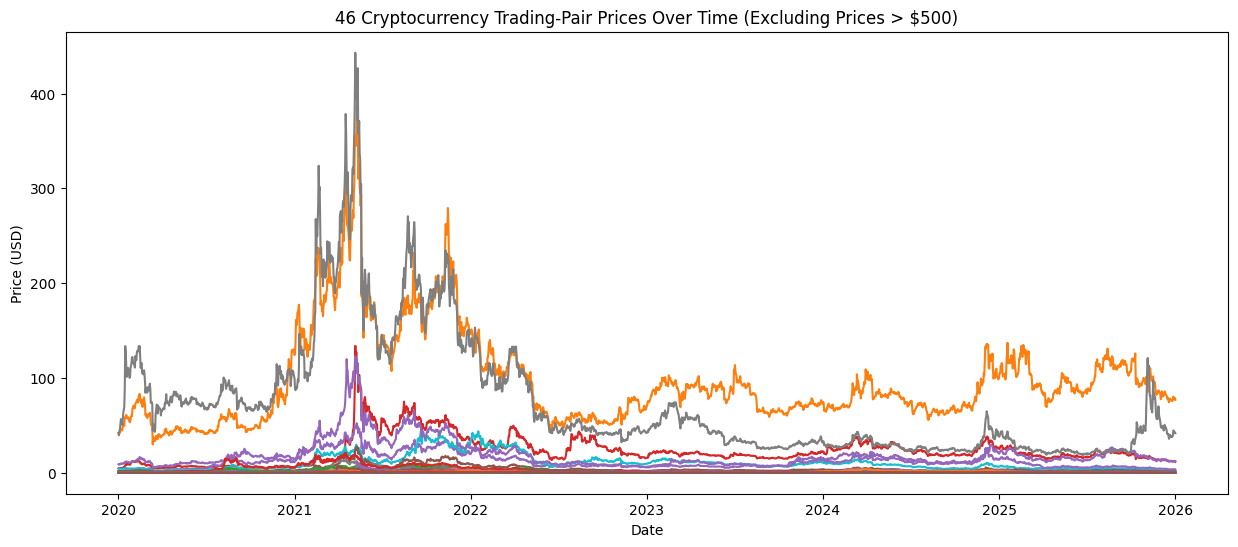

In [7]:
threshold_price = 500
exclude_symbols = [symbol for symbol in trading_pairs_df.columns if trading_pairs_df[symbol].max() > threshold_price]

plot_data = trading_pairs_df.drop(columns=exclude_symbols)

plt.figure(figsize=(15, 6))
for column in plot_data.columns:
  plt.plot(plot_data.index, plot_data[column], label=column)

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'{len(plot_data.columns)} Cryptocurrency Trading-Pair Prices Over Time (Excluding Prices > ${threshold_price})')
plt.show()

**Split the dataset for training and testing**

- Train: 2020 - 2024
- Test: 2025

In [8]:
# Select our training set which comprise of data from 2020 to 2024
trading_pairs_df.index = pd.to_datetime(trading_pairs_df.index)
train_data = trading_pairs_df[(trading_pairs_df.index > train) & (trading_pairs_df.index <= test)]
test_data = trading_pairs_df[trading_pairs_df.index > test]

#### **4. Crypto Strategy**

**Momentum Strategy to deploy**: *Cross-Sectional Rolling Mean Momentum Strategy*

The intuition here is that assets that performed well over a given time period will display momentum and continue its outperformance in the short run, while assets that delivered poorer returns will continue to underperform in the short run.

Description of the strategy:
- We will be using a rolling window to calculate the rolling return for each asset.
- We will rank these trading pairs based on their rolling returns and select the top 10 for holding in our portfolio over a period of time.
- Portfolio rebalancing happens after the holding period interval has been met, where the rolling mean rank orders are recalculated and the asset constitution reevaluated.

##### a. Grid-Search

To identify the ideal rolling window and holding period in our training data. We can initialise the strategy over a range of values:
- Rolling Window (1 - 50 days)
- Holding Period (1 - 50 days)

For each set of rolling window and holding period, we will be calculating the Sharpe Ratio

##### b. Signal Generation and Backtesting

We will define a function that computes the long signals and weights for each asset across time given the rolling window used. As for the weights assignment between each rebalancing date, it will be forward filled with the values derived at each evaluation period

In [9]:
def rolling_window_strategy(dataframe, num_of_assets, rolling_window, holding_period):
  """
  Computational logic for portfolio weights
  1. Compute rolling returns
  2. Rank assets ONLY on rebalance dates
  3. Assign equal weights to top X assets
  4. Forward-fill weights until next rebalance
  """
  df = dataframe.copy()
  asset_returns = df.pct_change()

  # Step 1: Rolling mean returns (momentum signal)
  rolling_returns = asset_returns.rolling(window=rolling_window).mean()

  # Step 2 Rank assets cross-sectionally
  ranks = rolling_returns.rank(axis=1, ascending=False)

  # Initialize portfolio weights with NaN (important for ffill)
  portfolio = pd.DataFrame(np.nan, index=df.index, columns=df.columns)

  # Rebalance dates (determined by holding period)
  rebalance_dates = df.index[::holding_period]

  for date in rebalance_dates:
    if date not in ranks.index: # i.e this is where we will simply skip the rebalancing if the date is not in ranks index
      continue
      
    # IMPORTANT: reset all weights to 0 on rebalance day
    portfolio.loc[date] = 0.0

    # Select top X assets based on ranks
    daily_ranks = ranks.loc[date].dropna()
    top_assets = daily_ranks.nlargest(num_of_assets).index

    # Step 3: Assign equal weights to top X assets
    portfolio.loc[date, top_assets] = 1 / num_of_assets

  # Forward-fill weights until next rebalance
  portfolio = portfolio.ffill()

  # Avoid look-ahead bias
  portfolio = portfolio.shift(1)

  # Strategy returns
  strategy_rets = (portfolio * asset_returns).sum(axis=1)
  return pd.DataFrame(strategy_rets, columns=["Strategy Return"])

def backtest_strategy(dataframe, rolling_window, holding_period, num_of_assets=5):
  performance_df = pd.DataFrame()
  sharpe = []
  rolling_window_list = []
  holding_period_list = []
  
  for rw in rolling_window:
    for hp in holding_period:
      strategy_returns = rolling_window_strategy(dataframe, num_of_assets, rolling_window=rw, holding_period=hp)
      strategy_returns = strategy_returns["Strategy Return"]
      sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
      rolling_window_list.append(rw)
      holding_period_list.append(hp)
      
  performance_df['Rolling Window'] = rolling_window_list
  performance_df['Holding Period'] = holding_period_list
  performance_df['Sharpe Ratio'] = sharpe
  
  return performance_df

def performance_heatmap(performance_df):
  # Sort rows (rolling window) ascending
  pivot_table = performance_df.sort_index(ascending=True)

  # Sort columns (holding period) ascending
  pivot_table = performance_df.sort_index(axis=1, ascending=True)

  # Plot a grid for visualising the best parameter pair
  pivot_table = performance_df.pivot(index="Rolling Window", columns="Holding Period", values="Sharpe Ratio")
  plt.figure(figsize=(8, 6))
  sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
  plt.title("Annualised Sharpe Ratio Heatmap")
  # Flip y-axis so rolling window ascends from bottom to top
  plt.gca().invert_yaxis()
  plt.tight_layout()
  plt.show()

Backtesting on our training data

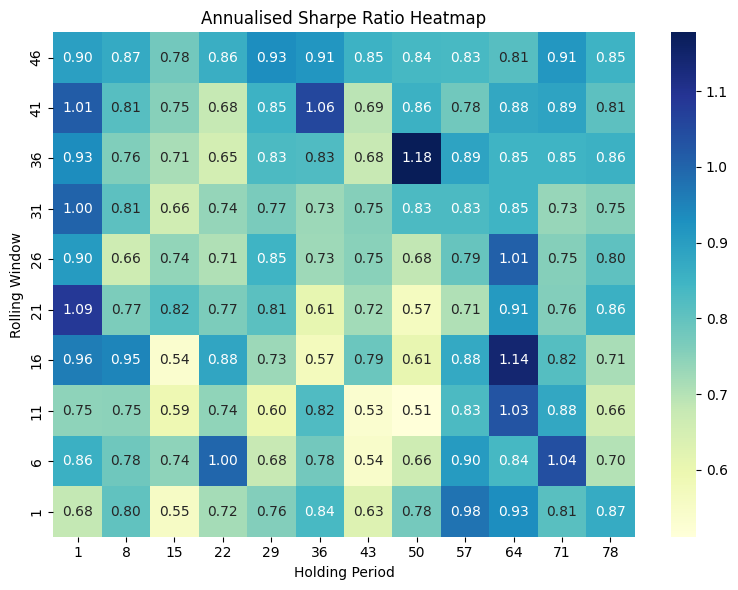

In [10]:
# initialise parameters for backtesting
rolling_window = np.arange(1, 50, 5).tolist() # Adjust the steps as needed
holding_period = np.arange(1, 80, 7).tolist() # Adjust the steps as needed

performance_results = backtest_strategy(train_data, rolling_window, holding_period, num_of_assets=5)
performance_heatmap(performance_results)

We can conclude from our grid search that a rolling window of 36 days and a holding period of 50 days yielded the highest annualised Sharpe of 1.18 in our training dataset.

##### c. Running the strategy on our basket of trading pairs

Given that our backtesting result yielded an optimal Sharpe with **36-day rolling window** and **50 days holding period**, we will implement and test this strategy using our test data

In [11]:
rolling_window_optimal = 36
holding_period_optimal = 50

# Running on the test set with optimal parameters
test_strategy_returns = rolling_window_strategy(test_data, num_of_assets=10, rolling_window=rolling_window_optimal, holding_period=holding_period_optimal)

# Benchmark: BTCUSDT huy and hold returns
test_benchmark_returns = test_data[['BTCUSDT']].pct_change()

#### **5. Performance Evaluation**

Let us define the functions to compute our strategy and benchmark performance metrics. As for the metrics that we will be using, they are:
1. Annualised Return
2. Annualised Volatility
3. Sharpe Ratio
4. Hit Rate
5. Max Drawdown
6. Drawdown Duration
7. Alpha and Beta
8. Information Ratio

As for the derivation of Alpha and Beta, we will be running a OLS linear regression of our portfolio returns on our benchmark. 

**Model Summary:**

$$
Portfolio_t \sim \alpha + \beta \times BTCUSDT_t + e_t
$$


- **Alpha (α)** measures **excess return** not explained by the market:
  - $\alpha > 0$: Strategy has **outperformed** what the market model predicts.
  - $\alpha < 0$: Strategy has **underperformed** relative to its market exposure.

- **Beta (β)** measures **systematic risk**:
  - $\beta > 1$: Strategy moves **more** than the market (high volatility, higher risk).
  - $\beta < 1$: Strategy moves **less** than the market (defensive behavior).
  - $\beta = 1$: Strategy moves roughly **in sync** with the market.

With the OLS regression model constructed, we can retrieve details on the following key variables:
- $\beta$: Our beta term which explains how correlated our asset is to the benchmark
- Portfolio<sub>t</sub>: Our predictor variable
- $\alpha$ + e<sub>t</sub>: The 'tradeable strategy' or the Alpha term and the residual


In [12]:
## Compute the performance metrics of our strategy
def strategy_performance_metrics(dataframe):
  df = dataframe.copy()
  # Annualised Return
  annualised_return = (1 + df['Strategy Return'].mean()) ** 252 - 1
  # Annualised Volatility
  annualised_volatility = df['Strategy Return'].std() * np.sqrt(252)
  # Sharpe Ratio
  sharpe_ratio = (df['Strategy Return'].mean() / df['Strategy Return'].std()) * np.sqrt(252)
  # Hit Rate
  hit_rate = (df['Strategy Return'] > 0).mean()
  
  # Drawdown for the strategy
  df['Strategy'] = (1 + df['Strategy Return']).cumprod()
  drawdown_values = draw_down(df[['Strategy']])
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
  
  drawdown_duration = draw_down_duration(df[['Strategy']])
  max_drawdown_duration = drawdown_duration.max().values[0]

  return {
    'Annualised Return': annualised_return,
    'Annualised Volatility': annualised_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Hit Rate': hit_rate,
    'Max Drawdown (%)': max_drawdown,
    'Max Drawdown Duration (Periods)': max_drawdown_duration
  }
  
def benchmark_performance_metrics(dataframe):
  df = dataframe.copy()
  df['Daily Return'] = df['BTCUSDT'].pct_change()
  # Annualised Return
  annualised_return = (1 + df['Daily Return'].mean()) ** 252 - 1
  # Annualised Volatility
  annualised_volatility = df['Daily Return'].std() * np.sqrt(252)
  # Sharpe Ratio
  sharpe_ratio = (df['Daily Return'].mean() / df['Daily Return'].std()) * np.sqrt(252)
  # Hit Rate
  hit_rate = (df['Daily Return'] > 0).mean()
  
  # Drawdown for the strategy
  df['Benchmark'] = (1 + df['Daily Return']).cumprod()
  drawdown_values = draw_down(df[['Benchmark']])
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
  
  drawdown_duration = draw_down_duration(df[['Benchmark']])
  max_drawdown_duration = drawdown_duration.max().values[0]

  return {
    'Annualised Return': annualised_return,
    'Annualised Volatility': annualised_volatility,
    'Sharpe Ratio': sharpe_ratio,
    'Hit Rate': hit_rate,
    'Max Drawdown (%)': max_drawdown,
    'Max Drawdown Duration (Periods)': max_drawdown_duration
  }
  
def compare_strat_and_benchmark(strat_metrics, benchmark_metrics):
  comparison = pd.DataFrame({
    'Strategy': strat_metrics,
    'Benchmark': benchmark_metrics
  })
  return comparison

def draw_down(px):
  return (px / px.expanding(min_periods=1).max() - 1)

def draw_down_duration(dataframe):
  px = dataframe.copy()
  peak = px.expanding(min_periods=1).max()
  res = pd.DataFrame(0, index=px.index, columns=px.columns)

  for col in px.columns:
    prev_duration = 0  # keeps track of last duration safely
    for dt in px.index:
      current_px = px.at[dt, col]
      current_peak = peak.at[dt, col]
      """ 
      if statement:
      - If the current price is equal to the running peak, it means we have hit a new all-time high, so the drawdown ends and duration resets to 0.
      
      else statement:
      - If the current price is below the peak, that means we are still in a drawdown. The code looks at the previous duration value (the second last row, .iloc[-2]),
        and then adds +1, meaning another period has passed since the last peak. So duration keeps counting how many consecutive periods we have been under the last peak.
      """
      if current_px >= current_peak:
        res.at[dt, col] = 0
        prev_duration = 0
      else:
        prev_duration += 1
        res.at[dt, col] = prev_duration

  return res

# Define the function to generate a dataframe containing price of each local maxima
def drawdown_with_line(dataframe):
  px = dataframe.copy()
  dataframe = pd.DataFrame(index=px.index,columns=px.columns)  
  peak = px.expanding(min_periods=1).max()
  
  for col in px.columns:
    for dt in px.index:
      """ This is a slight modification of the if statement used in the duration function.
      if the current price is equal to or greater than the running peak, we set the value in our new dataframe
      to the current price (indicating a new peak). Otherwise, we set it to the previous peak value.
      """
      if px.loc[dt,col] >= peak.loc[dt,col]:
        dataframe.loc[dt,col] = px.loc[dt,col]
      else:
        dataframe.loc[dt,col] = peak.loc[dt,col]
  return dataframe

def draw_down_plot(dataframe):
  dd = draw_down(dataframe)
  dd.plot(title='Drawdown of Asset Over Time')
  plt.title("Drawdowns")
  plt.xlabel("Date")
  plt.ylabel("Drawdown") 
  plt.gcf().set_size_inches(15, 6)
  plt.show()

def draw_down_duration_plot(dataframe):
  ddd = draw_down_duration(dataframe)
  ddd.plot(title=f'Duration of Drawdown of Strategy and Benchmark Over Time')
  plt.title("Drawdown Duration")
  plt.xlabel("Date")
  plt.ylabel("Duration (Periods)") 
  plt.gcf().set_size_inches(15, 6)
  plt.show()

def draw_down_line_plot(dataframe, column_name):
  # Plot the horizontal line to illustrate our drawdown in the chart for our portfolio and benchmark
  hdd = drawdown_with_line(dataframe)
  dd = draw_down(dataframe)
  horiz_line = hdd[column_name]
  print(f"Maximum drawdown for {column_name}: {round(dd[column_name].min() * -100, 2)}%")
  plt.figure(figsize=(15,6))
  plt.plot(dataframe[column_name], label=f'{column_name} Price')
  plt.plot(horiz_line, label='Drawdown Line', linestyle='--')
  plt.title(f"{column_name} Price with Drawdown Line")
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

def plot_strategy_performance_cumprod(strategy_rets, asset_returns):
  # Plot the cumulative returns of our strategy against the benchmark (BTCUSDT buy-and-hold)
  cumulative_strategy_rets = (1 + strategy_rets).cumprod() - 1
  cumulative_btc_rets = (1 + asset_returns['BTCUSDT'].pct_change()).cumprod() - 1
  plt.figure(figsize=(15, 6))
  plt.plot(cumulative_strategy_rets.index, cumulative_strategy_rets, label='Momentum Strategy', color='blue')
  plt.plot(cumulative_btc_rets.index, cumulative_btc_rets, label='BTCUSDT Buy-and-Hold', color='orange')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Cumulative Returns: Momentum Strategy vs BTCUSDT Buy-and-Hold')
  plt.legend()
  plt.show()
  
def plot_strategy_performance_cumsum(strategy_rets, asset_returns):
  # Plot the cumulative returns of our strategy against the benchmark (BTCUSDT buy-and-hold)
  # Convert to log returns before using cumsum
  cumulative_strategy_rets = strategy_rets.cumsum()
  cumulative_btc_rets = asset_returns['BTCUSDT'].pct_change().cumsum()
  plt.figure(figsize=(15, 6))
  plt.plot(cumulative_strategy_rets.index, cumulative_strategy_rets, label='Momentum Strategy', color='blue')
  plt.plot(cumulative_btc_rets.index, cumulative_btc_rets, label='BTCUSDT Buy-and-Hold', color='orange')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.title('Cumulative Returns: Momentum Strategy vs BTCUSDT Buy-and-Hold')
  plt.legend()
  plt.show()
  
# Derivation of Alpha and Beta using Linear Regression
def derive_alpha_beta(strategy_returns, benchmark_returns):
  df_reg = pd.concat([strategy_returns, benchmark_returns], axis=1)
  df_reg = df_reg.dropna()

  # set X and Y. Have to add constant
  X = df_reg[['Daily Return']] # Our independent variable
  X = sm.add_constant(X)  # Adds a constant term to the predictor
  Y = df_reg['Strategy Return'] # Our dependent variable
  
  results = sm.OLS(Y, X).fit()
  print(results.summary()) # Check the summary of our regression results
  
  """
  const is alpha
  Benchmark Returns is beta
  """
  print(f"Alpha: {results.params['const']}")
  print(f"Beta: {results.params['Daily Return']}")
  
  # Generate the regression plot
  beta_contr = results.params['Daily Return']*X['Daily Return']
  prediction = results.params['Daily Return']*X['Daily Return'] + results.params['const']
  alpha_contr = results.params['const'] + results.resid
  
  # Ensure correlation to benchmark is low to confirm market-neutrality
  print("Correlation between strategy returns and benchmark returns:", alpha_contr.corr(X['Daily Return']))
  
  # Our 3 key metrics
  print("Alpha:", alpha_contr.mean()) # This is the average return of the strategy
  print("Information Ratio:", alpha_contr.mean()/alpha_contr.std()*np.sqrt(252)) # This is the information ratio of the strategy
  print("Alpha t-stat:", results.tvalues['const']) # This is the t-stat of alpha
  
# Function to merge all plot into a single frame for easier viewing  
def combined_plots(strategy_rets, asset_returns):
  # Drawdown (%) and Duration
  combined = pd.concat([(1 + strategy_rets).cumprod(), (1 + asset_returns[['BTCUSDT']]).cumprod()], axis=1)
  combined.rename(columns={'Strategy Return':'Strategy', 'BTCUSDT':'Benchmark'}, inplace=True)
  dd = draw_down(combined)
  ddd = draw_down_duration(combined)
  
  # Cumulative Returns (cumprod)
  cumprod_strategy_rets = (1 + strategy_rets).cumprod() - 1
  cumprod_btc_rets = (1 + asset_returns['BTCUSDT']).cumprod() - 1
  
  # Cumulative Returns (cumsum)
  cumsum_strategy_rets = strategy_rets.cumsum()
  cumsum_btc_rets = asset_returns['BTCUSDT'].cumsum()
  

  # Alpha Component
  benchmark = asset_returns.copy()
  benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
  df_reg = pd.concat([strategy_rets, benchmark['Daily Return']], axis=1)
  df_reg = df_reg.dropna()

  # set X and Y. Have to add constant
  X = df_reg[['Daily Return']] # Our independent variable
  X = sm.add_constant(X)  # Adds a constant term to the predictor
  Y = df_reg['Strategy Return'] # Our dependent variable
  
  results = sm.OLS(Y, X).fit()
  alpha_contr = results.params['const'] + results.resid
  
  # Create a 2x3 subplot layout
  fig, ax = plt.subplots(2, 3, figsize=(20, 12))
  
  # Drawdown Plot
  dd.plot(ax=ax[0,0], title='Drawdown of Strategy and Benchmark Over Time')
  ax[0,0].set_xlabel("Date")
  ax[0,0].set_ylabel("Drawdown")
  
  # Drawdown Duration Plot
  ddd.plot(ax=ax[0,1], title='Duration of Drawdown of Strategy and Benchmark Over Time')
  ax[0,1].set_xlabel("Date")
  ax[0,1].set_ylabel("Duration (Periods)")
  
  # Cumulative Returns Plot (cumprod)
  ax[0,2].plot(cumprod_strategy_rets.index, cumprod_strategy_rets, label='Momentum Strategy')
  ax[0,2].plot(cumprod_btc_rets.index, cumprod_btc_rets, label='BTCUSDT Buy-and-Hold')
  ax[0,2].set_title('Cumulative Returns (Cumprod): Momentum Strategy vs BTCUSDT Buy-and-Hold')
  ax[0,2].set_xlabel('Date')
  ax[0,2].set_ylabel('Cumulative Return')
  ax[0,2].legend()
  
  # Cumulative Returns Plot (cumsum)
  ax[1,0].plot(cumsum_strategy_rets.index, cumsum_strategy_rets, label='Momentum Strategy')
  ax[1,0].plot(cumsum_btc_rets.index, cumsum_btc_rets, label='BTCUSDT Buy-and-Hold')
  ax[1,0].set_title('Cumulative Returns (Cumsum): Momentum Strategy vs BTCUSDT Buy-and-Hold')
  ax[1,0].set_xlabel('Date')
  ax[1,0].set_ylabel('Cumulative Return')
  ax[1,0].legend()
  
  # Alpha Component Plot
  alpha_contr.cumsum().plot(ax=ax[1,1], title="Cumulative Returns of Tradeable Strategy (Alpha) Component")
  ax[1,1].set_xlabel("Date")
  ax[1,1].set_ylabel("Cumulative Returns")
  
  plt.tight_layout()
  plt.show()

In [13]:
# Compare our strategy against the benchmark
test_strategy_returns_metrics = strategy_performance_metrics(test_strategy_returns)
benchmark_metrics = benchmark_performance_metrics(test_data)
performance_comparison = compare_strat_and_benchmark(test_strategy_returns_metrics, benchmark_metrics)
performance_comparison

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/3052410268.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/3052410268.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage


,Strategy,Benchmark
Annualised Return,-0.212186,0.014711
Annualised Volatility,0.629334,0.346389
Sharpe Ratio,-0.378782,0.042162
Hit Rate,0.434426,0.500000
Max Drawdown (%),64.169652,32.022515
Max Drawdown Duration (Periods),109.000000,116.000000


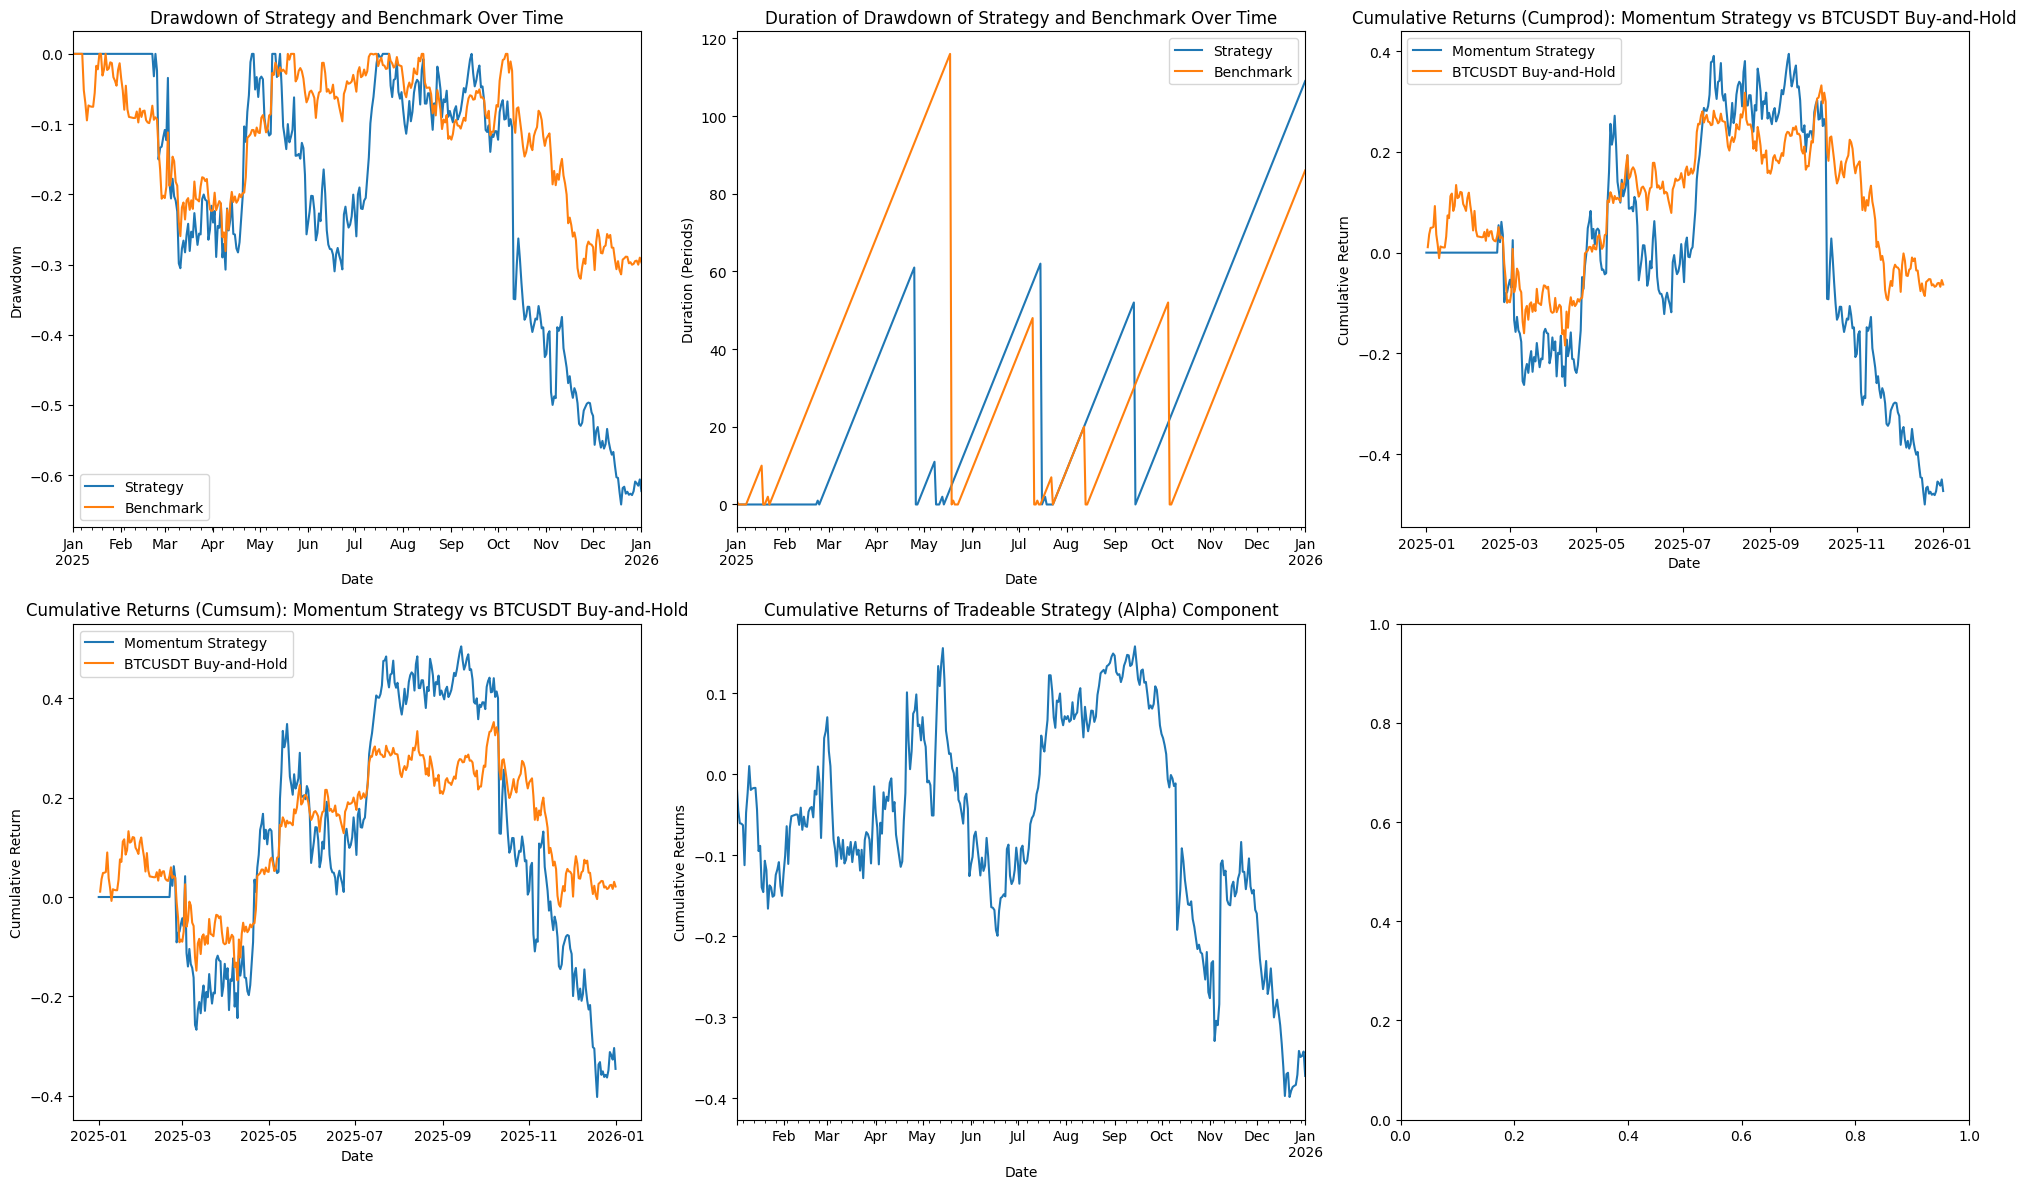

In [14]:
combined_plots(test_strategy_returns, test_benchmark_returns)

In [15]:
# Alpha and Beta of our Long-Only Strategy
benchmark = trading_pairs_df[['BTCUSDT']].pct_change()
benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
derive_alpha_beta(test_strategy_returns, benchmark)

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     329.3
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           7.12e-53
Time:                        22:47:57   Log-Likelihood:                 780.46
No. Observations:                 366   AIC:                            -1557.
Df Residuals:                     364   BIC:                            -1549.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0010      0.002     -0.697   

**Remarks:**

---

From the visualisation above and metrics above, we can conclude that a rolling window of 36 days and a holding period of 50 days yielded the highest annualised Sharpe of 1.18 on our training data, but failed to outperform the benchmark in our out-of-sample dataset (test).

Our strategy underperformed significantly from September 2025 onwards, which could have been attributed to some macro-related shock that was not captured in the model. Furthermore, we see that our strategy on average, had a higher annualised volatility of 0.629 compared to the benchmark's 0.346. Let us see how we can improve our strategy in the section below.

#### 7. Strategy Improvement

Given how volatility differs across various trading pairs, we might explore one option of creating an equal volatility portfolio, rather than assigning equal weights to our portfolio assets.

 **a. Equal Volatility Weights (`eqvol_weights`)**
   - Each asset is scaled inversely to its **volatility**, creating a **risk-parity-like allocation**.
   - Formula:  
     $$
     w_i \propto \frac{1}{\sqrt{\sigma_{ii}}}
     $$
   - This method **balances risk contribution** rather than dollar exposure, giving **lower-volatility assets more weight**. More formally, we can define the normalised form of the inverse volatility weights formula as follow:
     $$
     w_i = \frac{\frac{1}{\sqrt{\sigma_{ii}}}}{\sum{\frac{1}{\sqrt{\sigma_{ii}}}}}
     $$

As such, we can define our function for equal volatility weighting as shown below. For the derivation of sigma, which is our covariance matrix, we will be computing it from the rolling window of the top X stocks that we have chosen.

In [16]:
def eqvol_weights(sigma):
  wgt = 1/np.sqrt(np.diag(sigma))
  wgt = wgt / np.abs(wgt).sum()
  return wgt

def eqvol_weights_computation(dataframe):
  """
  1. Compute the covariance matrix from the dataframe of the X assets that we have chosen
  2. Use the eqvol_weights function to compute the equal volatility weights
  3. Return the weights as a pandas Series
  """
  # Step 1: Define our correlation matrix and convert it to a numpy array
  corr = dataframe.corr().values
  corr = np.array(corr)
    
  # Step 2: Compute our volatilities and convert it to a covariance matrix: sigma = D @ corr @ D
  vols = np.diag(dataframe.std().values) / np.sqrt(252) # daily vols of our X assets  
  sigma = vols @ corr @ vols # covariance matrix
    
  # Compute the equal volatility weights using the eqvol_weights function
  weights = eqvol_weights(sigma)
  # Return the weights as a pandas Series with the index as the asset names
  return pd.Series(weights, index=dataframe.columns)

With that, we can update our rolling window strategy function to incorporate the equal volatility weighting method

In [17]:
def rolling_window_equal_vol_strategy(dataframe, num_of_assets, rolling_window, holding_period):
  """
  Computational logic for portfolio weights
  1. Compute rolling returns
  2. Rank assets ONLY on rebalance dates
  3. Using the equal volatility weights method, equal-vol weight our top X assets
  4. Forward-fill weights until next rebalance
  """
  df = dataframe.copy()
  asset_returns = df.pct_change()

  # Step 1: Rolling mean returns (momentum signal)
  rolling_returns = asset_returns.rolling(window=rolling_window).mean()

  # Step 2 Rank assets cross-sectionally
  ranks = rolling_returns.rank(axis=1, ascending=False)

  # Initialize portfolio weights with NaN (important for ffill)
  portfolio = pd.DataFrame(np.nan, index=df.index, columns=df.columns)

  # Rebalance dates (determined by holding period)
  rebalance_dates = df.index[::holding_period]

  for date in rebalance_dates:
    if date not in ranks.index: # i.e this is where we will simply skip the rebalancing if the date is not in ranks index
      continue
      
    # IMPORTANT: reset all weights to 0 on rebalance day
    portfolio.loc[date] = 0.0

    # Select top X assets based on ranks
    daily_ranks = ranks.loc[date].dropna()
    top_assets = daily_ranks.nlargest(num_of_assets).index

    # Step 3: Using the equal volatility weights method, equal-vol weight our top X assets
    top_assets_data = df[top_assets].loc[:date].tail(rolling_window)
    eqvol_wgts = eqvol_weights_computation(top_assets_data)
    for asset in top_assets:
      portfolio.loc[date, asset] = eqvol_wgts[asset]
    
  # Forward-fill weights until next rebalance
  portfolio = portfolio.ffill()

  # Avoid look-ahead bias
  portfolio = portfolio.shift(1)
  
  # Strategy returns
  strategy_rets = (portfolio * asset_returns).sum(axis=1)
  return pd.DataFrame(strategy_rets, columns=["Strategy Return"])

def backtest_eq_vol_strategy(dataframe, rolling_window, holding_period, num_of_assets=5):
  performance_df = pd.DataFrame()
  sharpe = []
  rolling_window_list = []
  holding_period_list = []
  
  for rw in rolling_window:
    for hp in holding_period:
      strategy_returns = rolling_window_equal_vol_strategy(dataframe, num_of_assets, rolling_window=rw, holding_period=hp)
      strategy_returns = strategy_returns["Strategy Return"]
      sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
      rolling_window_list.append(rw)
      holding_period_list.append(hp)
      
  performance_df['Rolling Window'] = rolling_window_list
  performance_df['Holding Period'] = holding_period_list
  performance_df['Sharpe Ratio'] = sharpe
  
  return performance_df

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/2435081.py:61: RuntimeWarning: invalid value encountered in scalar divide
  sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/2435081.py:61: RuntimeWarning: invalid value encountered in scalar divide
  sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/2435081.py:61: RuntimeWarning: invalid value encountered in scalar divide
  sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/2435081.py:61: RuntimeWarning: invalid value encountered in scalar divide
  sharpe.append(np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())) # Annualized Sharpe Ratio
/var/folders

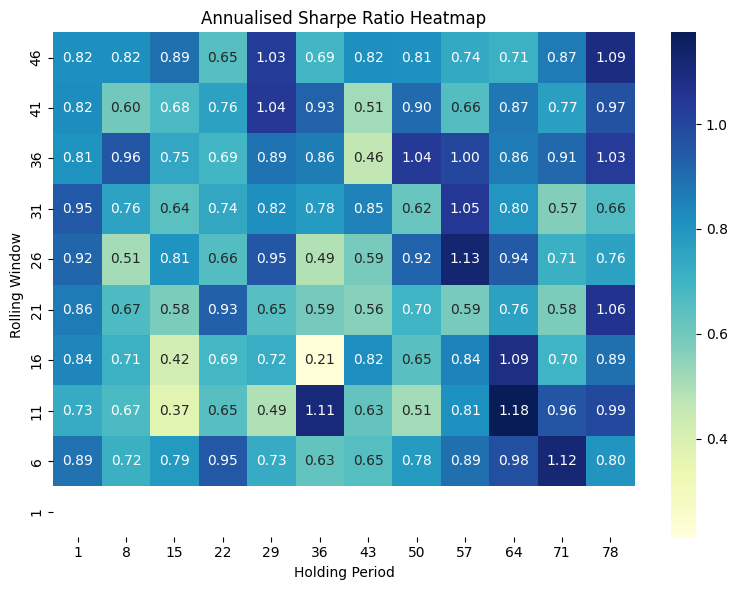

In [18]:
# Verify the implementation of the equal-volatility weighting strategy by backtesting it on the training set and plotting the heatmap
eq_vol_performance_results = backtest_eq_vol_strategy(train_data, rolling_window, holding_period, num_of_assets=5)
performance_heatmap(eq_vol_performance_results)

Let us recompute the performance of our updated strategy with the updated optimal rolling window and holding period. For this we will be using the optimised values of 
- rolling_window_optimal = 26
- holding_period_optimal = 57

Which will yield a high annualised sharpe 1.13. We avoid using the optimal pairs that yielded 1.18 in the heatmap above as our holding period of 11 days is generally too short.

In [25]:
rolling_window_optimal = 26
holding_period_optimal = 57
test_strat_equal_vol_returns = rolling_window_equal_vol_strategy(test_data, num_of_assets=10, rolling_window=rolling_window_optimal, holding_period=holding_period_optimal)

In [26]:
# Compare our strategy against the benchmark
test_strategy_equal_vol_returns_metrics = strategy_performance_metrics(test_strat_equal_vol_returns)
benchmark_metrics = benchmark_performance_metrics(test_data)
performance_comparison = compare_strat_and_benchmark(test_strategy_equal_vol_returns_metrics, benchmark_metrics)
performance_comparison

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/3052410268.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage
/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2027/3052410268.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_drawdown = drawdown_values.min()[0] * -100 # Convert to positive percentage


,Strategy,Benchmark
Annualised Return,0.543730,0.014711
Annualised Volatility,1.018845,0.346389
Sharpe Ratio,0.426538,0.042162
Hit Rate,0.415301,0.500000
Max Drawdown (%),72.228194,32.022515
Max Drawdown Duration (Periods),163.000000,116.000000


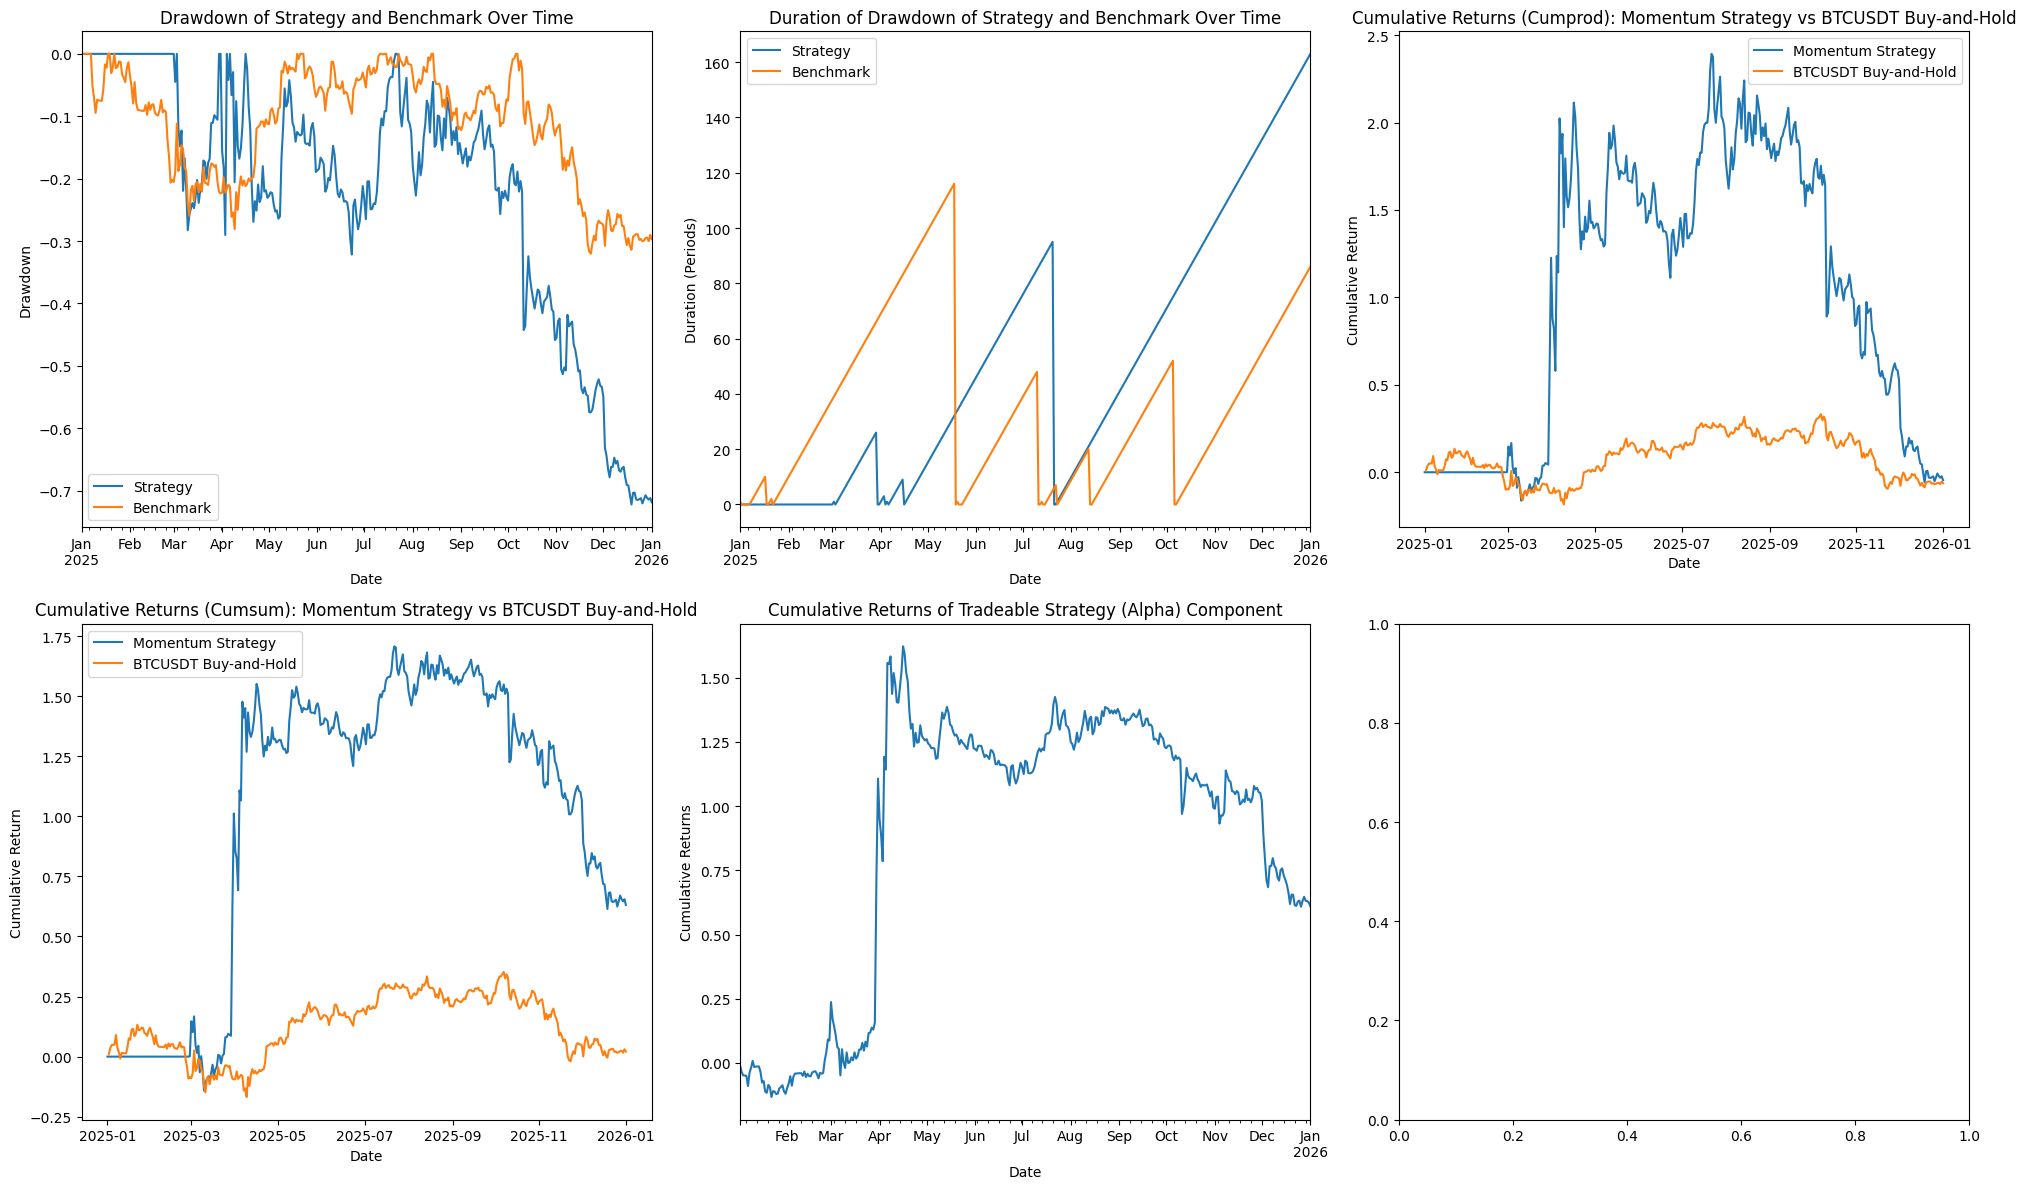

In [27]:
combined_plots(test_strat_equal_vol_returns, test_benchmark_returns)

In [28]:
# Alpha and Beta of our Long-Only Equal Vol Strategy
benchmark = trading_pairs_df[['BTCUSDT']].pct_change()
benchmark.rename(columns={'BTCUSDT':'Daily Return'}, inplace=True)
derive_alpha_beta(test_strat_equal_vol_returns, benchmark)

                            OLS Regression Results                            
Dep. Variable:        Strategy Return   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     47.36
Date:                Mon, 12 Jan 2026   Prob (F-statistic):           2.59e-11
Time:                        22:48:52   Log-Likelihood:                 508.61
No. Observations:                 366   AIC:                            -1013.
Df Residuals:                     364   BIC:                            -1005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0016      0.003      0.520   

**Remarks:**

---

After adjusting for equal volatility weighting of our portfolio after the top X stock selection, we can see that our Sharpe Ratio has increased to 0.426, which outperformed the benchmark. However, our annualised volatility has actually increased compared to our first iteration, and our max drawdown has actually increased too.

Almost all metrics improved but in terms of max drawdown and annualised volatility, our strategy still suffered in comparison to the benchmark

#### 8. Modelling Transaction Cost and other Factors

**Step 1: Computing turnover**

Turnover measures how frequently the portfolio positions change. To do so, we will perform the following actions
  1. Any missing weights (NaN) are replaced with 0. This ensures that when assets are added or removed from the universe, their contribution to turnover is treated cleanly — as if there were no position
  2. port.shift() moves the entire DataFrame one row down in time, so each row can be compared to the previous portfolio. This represents the portfolio weights at the previous timestamp.
  3. We compute the difference between the portfolio weights at the present and previous timestamps. This measures the change in portfolio weights for each asset between two consecutive time steps. If a weight stays the same, the difference is 0. If it changes, the difference reflects the amount of reallocation (buying/selling).
  4. Taking the absolute value converts all changes into positive numbers — since turnover measures how much the portfolio changes, not the direction.
  4. Summing across all columns (assets) at each timestamp gives the total portfolio turnover per period. For example, if the portfolio sold 0.3 of BTC and bought 0.3 of ETH, the turnover would be 0.3 + 0.3 = 0.6.


**Step 2: Compute the Gross of Transaction Costs**
  
This calculation ignores trading frictions such as slippage, bid-ask spreads, and commissions. The term “gross” indicates that this is the raw performance — before subtracting any turnover-related costs. as well as the portfolio Sharpe Ratio. To do so, we will perform the series of steps below:

1. **port.shift()**: The portfolio weights are shifted one period backward in time. This ensures we are using the weights decided at time t-1 to measure returns realized at time t. This avoids lookahead bias as you cannot trade on information you do not yet have.
2. **(port.shift() * ret)**: Here we multiply the previous period’s weights by the current period’s asset returns. This gives the contribution of each asset to the portfolio’s total return at time t.
3. **.sum(1)**: Summing across assets (axis = 1) adds up all contributions to get the portfolio’s overall return at each timestamp.

**Step 3: Net of Realise Returns**

This final step adjusts the portfolio’s gross returns to account for transaction costs, yielding the net realized returns.

**1. `tcost_bps = 20`**

Transaction cost per unit of turnover is assumed to be **20 basis points (bps)**.
- 1 basis point (bp) = 0.01%, so  
- **20 bps = 0.20% = 0.0020** in decimal form.

As defined above, we will be using 0.2% for our market order fee. This includes both **commissions** (e.g., exchange fees) and **slippage** (price impact when trading).

**2. `to * tcost_bps * 1e-4`**

Recall that:
- `to` is **turnover**, the total fraction of the portfolio traded between time steps.
- `tcost_bps * 1e-4` converts basis points to a **decimal cost per unit turnover**.

So, for each timestamp:
$$
\text{Transaction Cost}_t = \text{Turnover}_t \times \text{Cost per Unit Turnover}
$$

**Example:**
If turnover = 0.6 (i.e., 60% of the portfolio was traded), and cost = 20 bps = 0.0020, then:
$$
\text{Transaction Cost}_t = 0.6 \times 0.0020 = 0.0012 = 0.12\%
$$

**3. `gross_ret.subtract(..., fill_value=0)`**

Subtracts transaction costs from gross returns to compute **net returns**:
$$
\text{Net Return}_t = \text{Gross Return}_t - \text{Transaction Cost}_t
$$

The `fill_value=0` ensures missing values (NaNs) are treated as **0** during subtraction. This can be expressed in mathematical form as follow:
$$
\text{Net Return}_t = \sum_i w_{t-1,i} r_{t,i} - \text{Turnover}_t \times \text{Cost per Unit Turnover}
$$

Where:
- `gross_ret` → what your portfolio would earn in a **frictionless world**.  
- `to * tcost_bps * 1e-4` → represents the **drag from trading activity**.  
- `net_ret` → what you **actually keep** after paying for trading.

For this section, we will be sticking to the ```eqvol_weights``` improvement made to our strategy since the strategy's performance improved in general across all key metrics compared to the initial setup

In [23]:
def rolling_window_equal_vol_strategy_and_turnover(dataframe, num_of_assets, rolling_window, holding_period):
  """
  Computational logic for portfolio weights
  1. Compute rolling returns
  2. Rank assets ONLY on rebalance dates
  3. Using the equal volatility weights method, equal-vol weight our top X assets
  4. Forward-fill weights until next rebalance
  5. Return both strategy returns and portfolio weights for turnover computation
  """
  df = dataframe.copy()
  asset_returns = df.pct_change()

  # Step 1: Rolling mean returns (momentum signal)
  rolling_returns = asset_returns.rolling(window=rolling_window).mean()

  # Step 2 Rank assets cross-sectionally
  ranks = rolling_returns.rank(axis=1, ascending=False)

  # Initialize portfolio weights with NaN (important for ffill)
  portfolio = pd.DataFrame(np.nan, index=df.index, columns=df.columns)

  # Rebalance dates (determined by holding period)
  rebalance_dates = df.index[::holding_period]

  for date in rebalance_dates:
    if date not in ranks.index: # i.e this is where we will simply skip the rebalancing if the date is not in ranks index
      continue
      
    # IMPORTANT: reset all weights to 0 on rebalance day
    portfolio.loc[date] = 0.0

    # Select top X assets based on ranks
    daily_ranks = ranks.loc[date].dropna()
    top_assets = daily_ranks.nlargest(num_of_assets).index

    # Step 3: Using the equal volatility weights method, equal-vol weight our top X assets
    top_assets_data = df[top_assets].loc[:date].tail(rolling_window)
    eqvol_wgts = eqvol_weights_computation(top_assets_data)
    for asset in top_assets:
      portfolio.loc[date, asset] = eqvol_wgts[asset]
    
  # Forward-fill weights until next rebalance
  portfolio = portfolio.ffill()

  # Avoid look-ahead bias
  portfolio = portfolio.shift(1)
  
  # Strategy returns
  strategy_rets = (portfolio * asset_returns).sum(axis=1)
  return pd.DataFrame(strategy_rets, columns=["Strategy Return"]), portfolio
 
# Define the function to compute turnover
def compute_turnover(weights_dataframe, returns_dataframe):
  wdf = weights_dataframe.copy()
  to = (wdf.fillna(0) - wdf.shift().fillna(0)).abs().sum(1)

  # Plot the turnover over time
  plt.figure(figsize=(15,6))
  plt.plot(to.index, to, label='Turnover')
  plt.xlabel('Date')
  plt.ylabel('Turnover')
  plt.title('Portfolio Turnover Over Time')
  plt.legend()
  plt.show()
  
  print(f"Average Turnover: {to.mean()}")
  
  # Gross of transaction costs returns
  gross_ret = returns_dataframe
  print("Gross of transaction cost returns", (gross_ret.mean() / gross_ret.std() * np.sqrt(252))[0])
  
  # Net of transaction costs returns
  """
  Some small adjustments to be made: Since our gross_return (i.e strat return may not have the same dates as the turnover series), we will align them to turnover dates
  This will not be an issue since we are using the rolling window strategy which will have some NaN values at the start before hitting the rolling window period
  1. Reindex the gross_ret to match the index of the turnover series
  2. Fill any NaN values with 0, since on those dates we have no trades and hence no returns
  3. Compute the transaction costs as turnover * market_order_fee
  4. Subtract the transaction costs from the gross returns to get the net returns
  5. Compute the net returns performance metrics
  6. Print the net returns performance metrics
  """
  gross_ret = gross_ret.reindex(to.index).fillna(0)

  tcost_bps = market_order_fee
  trans_cost = pd.DataFrame(data = to*tcost_bps, index=gross_ret.index, columns=['Transaction Cost'])
  returns_tcost_df = pd.concat([gross_ret, trans_cost], axis=1)
  returns_tcost_df['Net Return'] = returns_tcost_df['Strategy Return'] - returns_tcost_df['Transaction Cost']

  net_return = returns_tcost_df['Net Return']
  print("Net Return after transaction costs:", net_return.sum())
  print("Annualised Sharpe Ratio after transaction costs:", net_return.mean() / net_return.std() * np.sqrt(252))

In [24]:
strategy_eqvol_assets, strategy_eqvol_weights = rolling_window_equal_vol_strategy_and_turnover(test_data, num_of_assets=10, rolling_window=rolling_window_optimal, holding_period=holding_period_optimal)

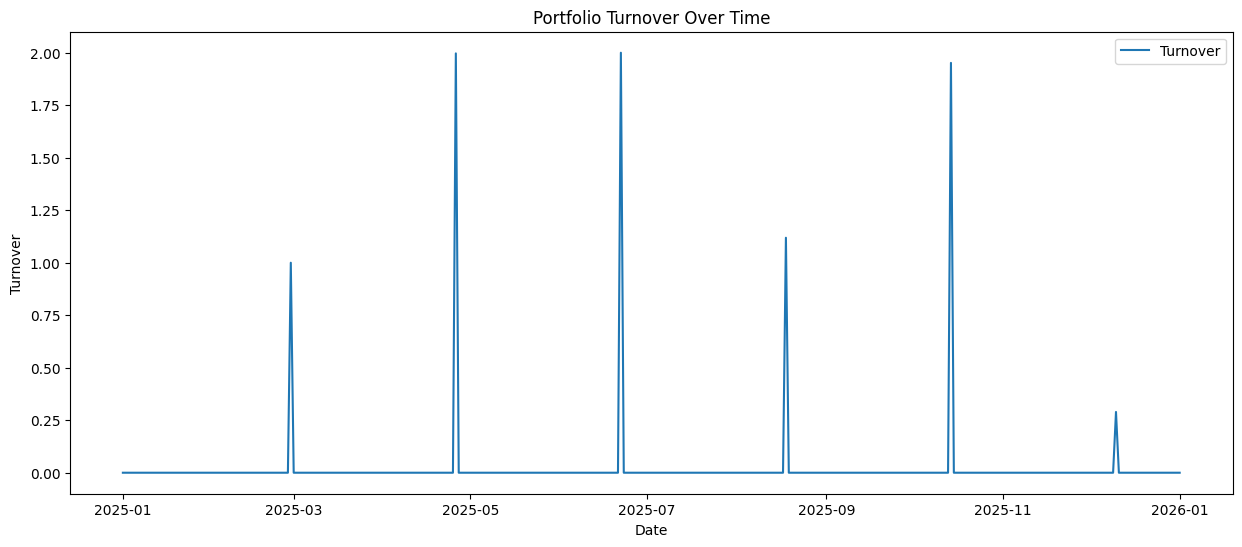

Average Turnover: 0.022832676126914128
Gross of transaction cost returns 0.4265380687333003
Net Return after transaction costs: 0.614456507407568
Annualised Sharpe Ratio after transaction costs: 0.4152657504984854


/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_2154/1820601706.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Gross of transaction cost returns", (gross_ret.mean() / gross_ret.std() * np.sqrt(252))[0])


In [25]:
compute_turnover(strategy_eqvol_weights, strategy_eqvol_assets)

#### **8. Potential Model Shortfalls and Limitations**

Overall, we can see that our improved **rolling mean equal-volatility momentum strategy** outperformed the benchmark with a higher annualised Sharpe Ratio of 0.427, which outperformed the benchmark which had a Sharpe of **0.042**. Furthermore, our strategy's turnover is relatively low, given that our holding period is *57 days*. As such, we were able to achieve a net return of 0.614 and an annualised Sharpe after transaction costs of *0.415*

One downside in our strategy, as seen from the metrics, is that it is still relatively volatile despite constructing an equal volatility portfolio. By looking at the charts above, we can once again see the underperformance happening at around the September period of 2025, where our momentum strategy's return nosedive.

Further research showed that seasonality effects kicked into the broader markets, as September is well known for its negative seasonals in tradfi financial assets. Bitcoin, our crypto benchmark, has an average monthly return of -3.12%. Beyond that, we can also see that the period between September - December 2025 proved to be a *volatile and risk-off* period for many cryptocurrencies, that saw a sharp fall in prices across most days.


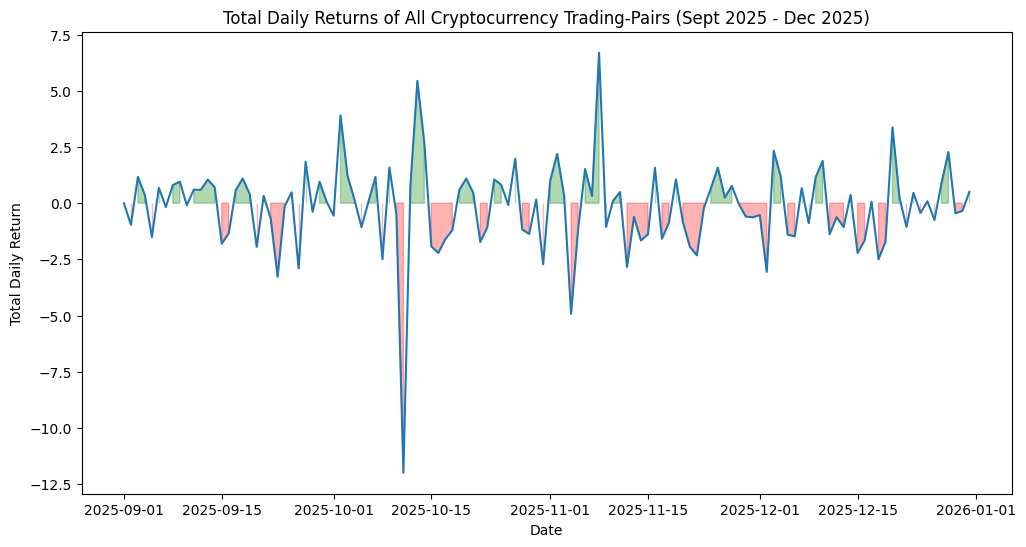

In [26]:
# Extracting data from Sept 2025 to Dec 2025 for inspection
inspection_start_date = "2025-09-01"
inspection_end_date = "2025-12-31"
inspection_data = trading_pairs_df[(trading_pairs_df.index >= inspection_start_date) & (trading_pairs_df.index <= inspection_end_date)]

# Caculate the percentage change for the inspection data
inspection_data = inspection_data.pct_change()

# Horiontal summation of all trading pairs for each date
inspection_data = inspection_data.sum(axis=1).to_frame()

# Plot the inspection data with positive values being green and negative values being red
plt.figure(figsize=(12, 6))
for column in inspection_data.columns:
  plt.plot(inspection_data.index, inspection_data[column], label=column)
  plt.fill_between(inspection_data.index, 0, inspection_data[column], where=(inspection_data[column] >= 0), color='green', alpha=0.3)
  plt.fill_between(inspection_data.index, 0, inspection_data[column], where=(inspection_data[column] < 0), color='red', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Total Daily Return')
plt.title('Total Daily Returns of All Cryptocurrency Trading-Pairs (Sept 2025 - Dec 2025)')
plt.show()


This will not bode well for our long-only porfolio, which is 100% invested across the entire period of analysis. This means that if momentum is positive, we will continue to benefit from a rise in the trading pair's prices. However, if all trading pairs declined, our strategy will still long the declining trading pairs. 

#### **9. Conclusion**

Overall, the momentum strategy demonstrates viable performance and outperforms the benchmark across both the training and testing periods. However, this outperformance was not sustained during broader market corrections, highlighting several structural limitations of the approach. In particular, the long-only constraint exposes the portfolio to downside risk when selected assets experience negative momentum, while the fully invested allocation forces capital to remain deployed even during unfavorable market conditions.
These findings suggest that a long-only momentum strategy may be suboptimal in the highly volatile cryptocurrency market, especially during prolonged drawdowns. Additionally, the testing period likely captured phases of general market decline, which may have masked the true effectiveness of the strategy. Future enhancements could include incorporating short positions, dynamic cash allocations, and evaluating the strategy over a broader universe of cryptocurrencies and a longer time horizon to better assess robustness and performance across market regimes.